In [ ]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_weekly_items_sales = pd.read_csv('/content/drive/MyDrive/Data Science - Master/project DSMarket/weekly_items_sales.csv', index_col=0)

In [ ]:
# specify the format since otherwise it might give some problems
df_weekly_items_sales["date"] = pd.to_datetime(df_weekly_items_sales["date"], format = "%Y-%m-%d")
df_weekly_items_sales.drop('sell_price', axis=1, inplace=True)
df_weekly_items_sales.rename(columns={'sell_price_imputed': 'sell_price'}, inplace=True)

In [ ]:
df_weekly_items_sales.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
region        0
date          0
quantity      0
event         0
sell_price    0
dtype: int64

In [ ]:
df_weekly_items_sales["revenue"] = df_weekly_items_sales["quantity"] * df_weekly_items_sales["sell_price"]

In [ ]:
df_weekly_items_sales.head(5)

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price,revenue
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-01-30,0,0,12.7414,0.0
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-06,0,1,12.7414,0.0
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-13,0,0,12.7414,0.0
3,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-20,0,0,12.7414,0.0
4,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-02-27,0,0,12.7414,0.0


In [ ]:
df_weekly_items_sales.shape

(8354260, 12)

In [ ]:
df_agg = df_weekly_items_sales.groupby(['store_code', 'id']).agg({'revenue': np.sum})

In [ ]:
g = df_agg['revenue'].groupby('store_code', group_keys=False)

In [ ]:
res = g.apply(lambda x: x.sort_values(ascending=False).head(5))
res

store_code  id                       
BOS_1       SUPERMARKET_3_586_BOS_1      214077.0240
            SUPERMARKET_3_202_BOS_1      189039.3720
            SUPERMARKET_3_090_BOS_1      150749.2080
            SUPERMARKET_3_587_BOS_1      133226.7960
            SUPERMARKET_3_555_BOS_1      131296.1760
BOS_2       SUPERMARKET_3_586_BOS_2      367694.7600
            SUPERMARKET_3_202_BOS_2      218220.0360
            SUPERMARKET_3_252_BOS_2      207848.8080
            SUPERMARKET_3_090_BOS_2      194033.3400
            SUPERMARKET_3_555_BOS_2      185380.6560
BOS_3       ACCESORIES_1_354_BOS_3       342934.0894
            SUPERMARKET_3_586_BOS_3      285652.9920
            ACCESORIES_1_158_BOS_3       258352.4202
            SUPERMARKET_3_202_BOS_3      209726.7600
            SUPERMARKET_3_090_BOS_3      187339.6320
NYC_1       SUPERMARKET_3_120_NYC_1      369908.4240
            SUPERMARKET_3_090_NYC_1      206950.6080
            SUPERMARKET_3_586_NYC_1      167475.0960
        

In [ ]:
len(list(res.reset_index()['id']))

50

In [ ]:
top_items = list(res.reset_index()['id'])
top_items

['SUPERMARKET_3_586_BOS_1',
 'SUPERMARKET_3_202_BOS_1',
 'SUPERMARKET_3_090_BOS_1',
 'SUPERMARKET_3_587_BOS_1',
 'SUPERMARKET_3_555_BOS_1',
 'SUPERMARKET_3_586_BOS_2',
 'SUPERMARKET_3_202_BOS_2',
 'SUPERMARKET_3_252_BOS_2',
 'SUPERMARKET_3_090_BOS_2',
 'SUPERMARKET_3_555_BOS_2',
 'ACCESORIES_1_354_BOS_3',
 'SUPERMARKET_3_586_BOS_3',
 'ACCESORIES_1_158_BOS_3',
 'SUPERMARKET_3_202_BOS_3',
 'SUPERMARKET_3_090_BOS_3',
 'SUPERMARKET_3_120_NYC_1',
 'SUPERMARKET_3_090_NYC_1',
 'SUPERMARKET_3_586_NYC_1',
 'SUPERMARKET_3_202_NYC_1',
 'SUPERMARKET_3_587_NYC_1',
 'SUPERMARKET_1_012_NYC_2',
 'SUPERMARKET_3_586_NYC_2',
 'SUPERMARKET_3_252_NYC_2',
 'SUPERMARKET_3_090_NYC_2',
 'HOME_&_GARDEN_1_537_NYC_2',
 'SUPERMARKET_3_120_NYC_3',
 'SUPERMARKET_3_090_NYC_3',
 'SUPERMARKET_3_202_NYC_3',
 'SUPERMARKET_3_586_NYC_3',
 'SUPERMARKET_2_244_NYC_3',
 'ACCESORIES_1_147_NYC_4',
 'SUPERMARKET_3_202_NYC_4',
 'SUPERMARKET_3_090_NYC_4',
 'SUPERMARKET_3_120_NYC_4',
 'SUPERMARKET_2_244_NYC_4',
 'SUPERMARKET_3_226_P

In [ ]:
df_weekly_items_sales_filtered = df_weekly_items_sales[df_weekly_items_sales['id'].isin(top_items)]

In [ ]:
df_weekly_items_sales_filtered

,id,item,category,department,store,store_code,region,date,quantity,event,sell_price,revenue
284138,ACCESORIES_1_108_PHI_1,ACCESORIES_1_108,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2011-01-30,17,0,16.1196,274.0332
284139,ACCESORIES_1_108_PHI_1,ACCESORIES_1_108,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2011-02-06,36,1,16.1196,580.3056
284140,ACCESORIES_1_108_PHI_1,ACCESORIES_1_108,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2011-02-13,56,0,16.1196,902.6976
284141,ACCESORIES_1_108_PHI_1,ACCESORIES_1_108,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2011-02-20,42,0,16.1196,677.0232
284142,ACCESORIES_1_108_PHI_1,ACCESORIES_1_108,ACCESORIES,ACCESORIES_1,Midtown_Village,PHI_1,Philadelphia,2011-02-27,44,0,16.1196,709.2624
...,...,...,...,...,...,...,...,...,...,...,...,...
7998055,SUPERMARKET_3_694_PHI_3,SUPERMARKET_3_694,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-03-27,331,1,2.0160,667.2960
7998056,SUPERMARKET_3_694_PHI_3,SUPERMARKET_3_694,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-03,314,0,2.0160,633.0240
7998057,SUPERMARKET_3_694_PHI_3,SUPERMARKET_3_694,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-10,288,0,2.0160,580.6080
7998058,SUPERMARKET_3_694_PHI_3,SUPERMARKET_3_694,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,2016-04-17,345,0,2.0160,695.5200


# Resample por meses


In [ ]:
st = time.time()

gb_df = df_weekly_items_sales_filtered.set_index("date")

#group by id
gb_df= gb_df.groupby(['id'])

# # resample the sales to a weekly basis
gb_df = gb_df.resample("M").agg({'quantity':np.sum, "sell_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))

gb_df.head(5)

Total time in minutes to preprocess took 0.005348861217498779


,id,date,quantity,sell_price,revenue
0,ACCESORIES_1_108_PHI_1,2011-01-31,17,16.1196,274.0332
1,ACCESORIES_1_108_PHI_1,2011-02-28,178,16.1196,2869.2888
2,ACCESORIES_1_108_PHI_1,2011-03-31,163,16.1196,2627.4948
3,ACCESORIES_1_108_PHI_1,2011-04-30,167,16.1196,2691.9732
4,ACCESORIES_1_108_PHI_1,2011-05-31,233,16.1196,3755.8668


In [ ]:
min_date = gb_df["date"].min()
max_date_sales = gb_df["date"].max()

print(min_date)
print(max_date_sales)

2011-01-31 00:00:00
2016-04-30 00:00:00


In [ ]:
gb_df['date'].nunique()

64

In [ ]:
max_date_test = datetime(2016,5,31)

In [ ]:
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range

We have a total of 65 months


DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-31',
               '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
      

In [ ]:
unique_id = gb_df["id"].unique()
len(unique_id)

50

In [ ]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "id"])
len(cartesian_product)

3250

In [ ]:
print(len(cartesian_product) - gb_df.shape[0])
print((len(cartesian_product) - gb_df.shape[0]) / len(unique_id))

50
1.0


# Join Cartesian_Product & gb_df


In [ ]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df.head(10)

,date,id
0,2011-01-31,ACCESORIES_1_108_PHI_1
1,2011-01-31,ACCESORIES_1_147_NYC_4
2,2011-01-31,ACCESORIES_1_158_BOS_3
3,2011-01-31,ACCESORIES_1_345_PHI_1
4,2011-01-31,ACCESORIES_1_354_BOS_3
5,2011-01-31,HOME_&_GARDEN_1_072_PHI_2
6,2011-01-31,HOME_&_GARDEN_1_537_NYC_2
7,2011-01-31,SUPERMARKET_1_012_NYC_2
8,2011-01-31,SUPERMARKET_1_096_PHI_1
9,2011-01-31,SUPERMARKET_1_096_PHI_2


In [ ]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = gb_df,
    on = ["date", "id"],
    how = "left"
)

print(full_df.shape)

(3250, 2)
(3250, 5)


In [ ]:
full_df

,date,id,quantity,sell_price,revenue
0,2011-01-31,ACCESORIES_1_108_PHI_1,17.0,16.1196,274.0332
1,2011-01-31,ACCESORIES_1_147_NYC_4,0.0,13.2601,0.0000
2,2011-01-31,ACCESORIES_1_158_BOS_3,0.0,30.5634,0.0000
3,2011-01-31,ACCESORIES_1_345_PHI_1,0.0,9.8952,0.0000
4,2011-01-31,ACCESORIES_1_354_BOS_3,0.0,31.8934,0.0000
...,...,...,...,...,...
3245,2016-05-31,SUPERMARKET_3_586_PHI_3,NaN,NaN,NaN
3246,2016-05-31,SUPERMARKET_3_587_BOS_1,NaN,NaN,NaN
3247,2016-05-31,SUPERMARKET_3_587_NYC_1,NaN,NaN,NaN
3248,2016-05-31,SUPERMARKET_3_694_PHI_1,NaN,NaN,NaN


In [ ]:
full_df.isnull().sum()

date           0
id             0
quantity      50
sell_price    50
revenue       50
dtype: int64

In [ ]:
full_df[full_df["sell_price"].isnull()].sample(5)

,date,id,quantity,sell_price,revenue
3242,2016-05-31,SUPERMARKET_3_586_NYC_1,NaN,NaN,NaN
3234,2016-05-31,SUPERMARKET_3_252_BOS_2,NaN,NaN,NaN
3210,2016-05-31,SUPERMARKET_2_244_NYC_3,NaN,NaN,NaN
3226,2016-05-31,SUPERMARKET_3_202_BOS_2,NaN,NaN,NaN
3241,2016-05-31,SUPERMARKET_3_586_BOS_3,NaN,NaN,NaN


In [ ]:
full_df["quantity"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [ ]:
full_df["sell_price"] = full_df.groupby("id")["sell_price"].apply(lambda series: series.backfill().ffill())

In [ ]:
full_df.isnull().sum()

date          0
id            0
quantity      0
sell_price    0
revenue       0
dtype: int64

In [ ]:
print(df_weekly_items_sales_filtered.shape)
vars_to_add = df_weekly_items_sales_filtered[
    ["item", "category", "department", "store", "store_code", "region","id"]
].drop_duplicates()
print(vars_to_add.shape)

(13700, 12)
(50, 7)


In [ ]:
print(full_df.shape)
full_df = pd.merge(
    left = full_df,
    right = vars_to_add,
    on = ["id"],
    how = "left"
)
print(full_df.shape)

(3250, 5)
(3250, 11)


In [ ]:
class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        # joins the gb_list, this way we can dinamically create new columns
        # ["date, "shop_id] --> date_shop_id
        self.objective_column_name = "_".join(gb_list)
            
    def generate_gb_df(self):
        
        '''
        This function thakes the full_df and creates a groupby df based on the gb_list.
        It creates 2 columns: 
            1. A sum column for every date and gb_list
            2. Mean columns for every_date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            names = {
                # you can put here as many columns as you want 
                '{}_sum'.format(args):  full_df_['quantity'].sum(),
                '{}_mean'.format(args):  full_df_['quantity'].mean(),
            }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args = (self.objective_column_name)).reset_index()

        self.gb_df_ = gb_df_

        
    def return_gb_df(self):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix

            self.gb_df_['{}_shift_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: series.shift(1))
            
            self.gb_df_['{}_shift_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: series.shift(2))
            
            self.gb_df_['{}_shift_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: series.shift(3))

            self.gb_df_['{}_var_pct_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: (series.shift(1) - series.shift(2))/series.shift(2))
            
            self.gb_df_['{}_var_pct_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: (series.shift(1) - series.shift(3))/series.shift(3))
            
            self.gb_df_['{}_var_pct_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda series: (series.shift(1) - series.shift(4))/series.shift(4))
            
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
        # call the generate_shift_featues function with different suffix (sum and mean)
        generate_shift_features(self, suffix = "sum")
        generate_shift_features(self, suffix = "mean")
    
        return self.gb_df_

In [ ]:
st = time.time()

gb_list = ["date", "store_code", "region"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

shop_sales_features = fe_generator.return_gb_df()

shop_sales_features.drop("region", axis = 1, inplace = True)
et = time.time()

(et - st)/60

0.007850197950998943

In [ ]:
shop_sales_features.shape

(650, 16)

In [ ]:
st = time.time()

gb_list = ["date", "department"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_department_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.004466780026753743

In [ ]:
month_item_department_features.shape

(325, 16)

In [ ]:
st = time.time()

gb_list = ["date", "category"]

fe_generator = FeatureGenerator(full_df = full_df, gb_list = gb_list)

fe_generator.generate_gb_df()

month_item_category_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.003054968516031901

In [ ]:
month_item_category_features.shape

(195, 16)

In [ ]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "store_code"], how = "left")
full_df = pd.merge(full_df, month_item_department_features, on = ["date", "department"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "category"], how = "left")
full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (3250, 11)
Shape after merge is (3250, 53)


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# delete all the columns where lags features are - NA (ma3(5))
full_df_model = full_df[full_df["date"] > np.datetime64("2011-05-31")]

In [ ]:
cols_to_drop = ['revenue', 'item','category', 'department','store', 'store_code', 'region']

full_df_model.drop(cols_to_drop, inplace = True, axis = 1)

In [ ]:
full_df_model.reset_index(drop=True, inplace=True)
full_df_model

,date,id,quantity,sell_price,date_store_code_region_sum,date_store_code_region_mean,date_store_code_region_sum_shift_1,date_store_code_region_sum_shift_2,date_store_code_region_sum_shift_3,date_store_code_region_sum_var_pct_1,...,date_category_sum_shift_3,date_category_sum_var_pct_1,date_category_sum_var_pct_2,date_category_sum_var_pct_3,date_category_mean_shift_1,date_category_mean_shift_2,date_category_mean_shift_3,date_category_mean_var_pct_1,date_category_mean_var_pct_2,date_category_mean_var_pct_3
0,2011-06-30,ACCESORIES_1_108_PHI_1,180.0,15.9334,1895.0,379.0,2425.0,1995.0,2023.0,0.215539,...,306.0,0.453333,0.424837,0.568345,87.200000,60.000000,61.200000,0.453333,0.424837,0.568345
1,2011-06-30,ACCESORIES_1_147_NYC_4,0.0,13.2601,299.0,59.8,418.0,323.0,489.0,0.294118,...,306.0,0.453333,0.424837,0.568345,87.200000,60.000000,61.200000,0.453333,0.424837,0.568345
2,2011-06-30,ACCESORIES_1_158_BOS_3,0.0,30.5634,3650.0,730.0,3893.0,3151.0,3071.0,0.235481,...,306.0,0.453333,0.424837,0.568345,87.200000,60.000000,61.200000,0.453333,0.424837,0.568345
3,2011-06-30,ACCESORIES_1_345_PHI_1,118.0,9.8952,1895.0,379.0,2425.0,1995.0,2023.0,0.215539,...,306.0,0.453333,0.424837,0.568345,87.200000,60.000000,61.200000,0.453333,0.424837,0.568345
4,2011-06-30,ACCESORIES_1_354_BOS_3,0.0,31.8934,3650.0,730.0,3893.0,3151.0,3071.0,0.235481,...,306.0,0.453333,0.424837,0.568345,87.200000,60.000000,61.200000,0.453333,0.424837,0.568345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2016-05-31,SUPERMARKET_3_586_PHI_3,0.0,2.0160,0.0,0.0,6625.0,6520.0,6790.0,0.016104,...,47693.0,0.002783,-0.033024,-0.065207,1072.511628,1069.534884,1109.139535,0.002783,-0.033024,-0.065207
2996,2016-05-31,SUPERMARKET_3_587_BOS_1,0.0,2.9760,0.0,0.0,5132.0,5370.0,5360.0,-0.044320,...,47693.0,0.002783,-0.033024,-0.065207,1072.511628,1069.534884,1109.139535,0.002783,-0.033024,-0.065207
2997,2016-05-31,SUPERMARKET_3_587_NYC_1,0.0,2.9760,0.0,0.0,4664.0,4534.0,4826.0,0.028672,...,47693.0,0.002783,-0.033024,-0.065207,1072.511628,1069.534884,1109.139535,0.002783,-0.033024,-0.065207
2998,2016-05-31,SUPERMARKET_3_694_PHI_1,0.0,2.0160,0.0,0.0,2154.0,2241.0,2197.0,-0.038822,...,47693.0,0.002783,-0.033024,-0.065207,1072.511628,1069.534884,1109.139535,0.002783,-0.033024,-0.065207


In [ ]:
train_index = sorted(list(full_df["date"].unique()))[:-2]
print(train_index)
valida_index = [sorted(list(full_df["date"].unique()))[-2]]
print(valida_index)
test_index = [sorted(list(full_df["date"].unique()))[-1]]
print(test_index)

[numpy.datetime64('2011-01-31T00:00:00.000000000'), numpy.datetime64('2011-02-28T00:00:00.000000000'), numpy.datetime64('2011-03-31T00:00:00.000000000'), numpy.datetime64('2011-04-30T00:00:00.000000000'), numpy.datetime64('2011-05-31T00:00:00.000000000'), numpy.datetime64('2011-06-30T00:00:00.000000000'), numpy.datetime64('2011-07-31T00:00:00.000000000'), numpy.datetime64('2011-08-31T00:00:00.000000000'), numpy.datetime64('2011-09-30T00:00:00.000000000'), numpy.datetime64('2011-10-31T00:00:00.000000000'), numpy.datetime64('2011-11-30T00:00:00.000000000'), numpy.datetime64('2011-12-31T00:00:00.000000000'), numpy.datetime64('2012-01-31T00:00:00.000000000'), numpy.datetime64('2012-02-29T00:00:00.000000000'), numpy.datetime64('2012-03-31T00:00:00.000000000'), numpy.datetime64('2012-04-30T00:00:00.000000000'), numpy.datetime64('2012-05-31T00:00:00.000000000'), numpy.datetime64('2012-06-30T00:00:00.000000000'), numpy.datetime64('2012-07-31T00:00:00.000000000'), numpy.datetime64('2012-08-31T0

In [ ]:
X_train = full_df_model[full_df_model["date"].isin(train_index)].drop(['quantity','date', 'id'], axis=1)
Y_train = full_df_model[full_df_model["date"].isin(train_index)]['quantity']

X_valida = full_df_model[full_df_model["date"].isin(valida_index)].drop(['quantity','date', 'id'], axis=1)
Y_valida = full_df_model[full_df_model["date"].isin(valida_index)]['quantity']

X_test = full_df_model[full_df_model["date"].isin(test_index)].drop(['quantity','date', 'id'], axis = 1)
Y_test = full_df_model[full_df_model["date"].isin(test_index)]['quantity']

#Modelo

In [ ]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[17:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1362.24	validation_1-rmse:1050.14
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1257.8	validation_1-rmse:961.055
[2]	validation_0-rmse:1164.32	validation_1-rmse:877.256
[3]	validation_0-rmse:1082.51	validation_1-rmse:807.198
[4]	validation_0-rmse:1009.22	validation_1-rmse:741.045
[5]	validation_0-rmse:946.121	validation_1-rmse:690.037
[6]	validation_0-rmse:890.228	validation_1-rmse:640.968
[7]	validation_0-rmse:839.998	validation_1-rmse:598.775
[8]	validation_0-rmse:797.874	validation_1-rmse:562.424
[9]	validation_0-rmse:759.945	validation_1-rmse:531.797
[10]	validation_0-rmse:727.57	validation_1-rmse:505.131
[11]	validation_0-rmse:701.336	validation_1-rmse:484.713
[12]	validation_0-rmse:676.216	validation_

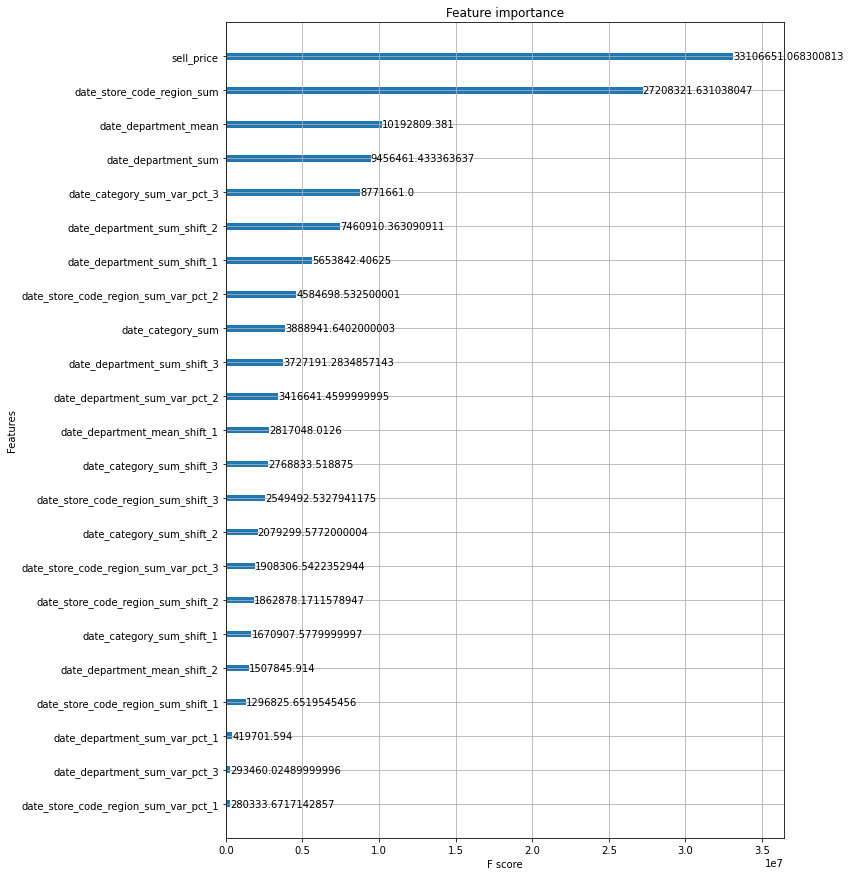

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [ ]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

350.411052466744

In [ ]:
Y_test_pred = model.predict(X_test)

In [ ]:
Y_valida_id = full_df_model[full_df_model["date"].isin(valida_index)][['id', 'quantity']].reset_index(drop=True, inplace=False).rename(columns={'quantity':'quantity_2016-04-30'})
Y_valida_pred_df =pd.DataFrame(Y_valida_pred).rename(columns={0:'quantity_pred_2016-04-30'})
Y_05_pred_df = pd.DataFrame(Y_test_pred, columns=['quantity_pred_2016-05-30'])

In [ ]:
pd.concat([Y_valida_id, Y_valida_pred_df, Y_05_pred_df], axis=1)

,id,quantity_2016-04-30,quantity_pred_2016-04-30,quantity_pred_2016-05-30
0,ACCESORIES_1_108_PHI_1,58.0,133.892822,56.616325
1,ACCESORIES_1_147_NYC_4,158.0,159.888168,75.352844
2,ACCESORIES_1_158_BOS_3,594.0,559.008118,24.713444
3,ACCESORIES_1_345_PHI_1,122.0,155.539032,75.352844
4,ACCESORIES_1_354_BOS_3,578.0,559.008118,24.713444
5,HOME_&_GARDEN_1_072_PHI_2,105.0,170.938126,88.767082
6,HOME_&_GARDEN_1_537_NYC_2,47.0,89.585808,56.323269
7,SUPERMARKET_1_012_NYC_2,408.0,606.488831,97.570724
8,SUPERMARKET_1_096_PHI_1,379.0,416.952057,143.840988
9,SUPERMARKET_1_096_PHI_2,1518.0,744.083496,143.840988
